In [1]:
import os
import cv2
from math import log10, sqrt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pylab import imshow, gray, show

In [2]:
# IGT Algorithm Class

class ImageBinarization:

    # Get the image name from path
    def get_image_name(self, img_path):
        return img_path.split('/')[-1]
        
    # Open image
    def open_image(self, image_path):
        img = Image.open(img_path).convert('L')
        return img
    # Convert image to numpy array
    def image_to_array(self, img):
        npimage = np.asarray(img)
        return npimage

    def process_image_global(self, npimage):
        npimage = npimage/255
        m, n = npimage.shape
        npimage_copy = npimage
        flag = True
        it_flag = True
        while 1:
            # Calculate mean of all pixels as threshold
            threshold = np.mean(npimage)
            if flag:
                old_threshold = threshold   # Will be used for termination condition
                flag = False
            
            # Subtract threshold from pixel
            npimage = (1 - threshold) + npimage
            for i in range(0, m):
                for j in range(0, n):
                    if npimage[i, j] > 1:
                        npimage[i, j] = 1
            
            # Hist equalization
            min_pixel_value = np.min(npimage)
            npimage = 1 - ((1 - npimage) / (1 - min_pixel_value))
            
            # Current image is old image for the next iteration
            npimage_copy = npimage
            old_threshold = threshold
            if it_flag  :
                it_flag = False
                continue
            count = 0
            
            # If the number of pixels transformed between 2 iterations < 3%, then we terminate
            for i in range(0, m):
                for j in range(0, n):
                    if npimage[i, j] > threshold and npimage_copy[i, j] <= old_threshold:
                        count += 1 
                    elif npimage[i, j] <= threshold and npimage_copy[i, j] > old_threshold:
                        count += 1
                        
            if count < (0.03 * m * n):
                break

        # If pixel is not already background(1), then convert to foreground(0)
        for i in range(0, m):
            for j in range(0, n):
                if npimage[i, j] == 1:
                    npimage[i, j] = 255
                else:
                    npimage[i, j] = 0
        
        return npimage

    # Driver function to run the whole process
    def driver_function(self, img_path):
        img = self.open_image(img_path)
        npimage = self.image_to_array(img)
        img_global = self.process_image_global(npimage)
        new_p = Image.fromarray(img_global)
        new_p = new_p.convert("L")
        img_name = self.get_image_name(img_path)
        output_path = '../quantitative_analysis/igt_results/' + img_name
        new_p.save(output_path)

In [3]:
# Run IGT algorithm for all images in the dataset
image_binarization = ImageBinarization()
for i in range(1, 6):
    img_path = "../quantitative_analysis/dataset/" + str(i) + ".bmp"
    image_binarization.driver_function(img_path)

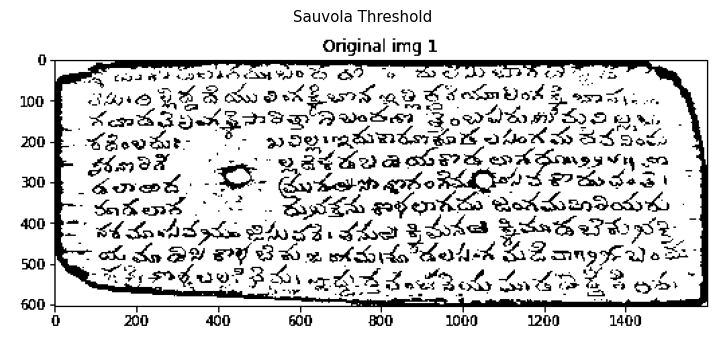

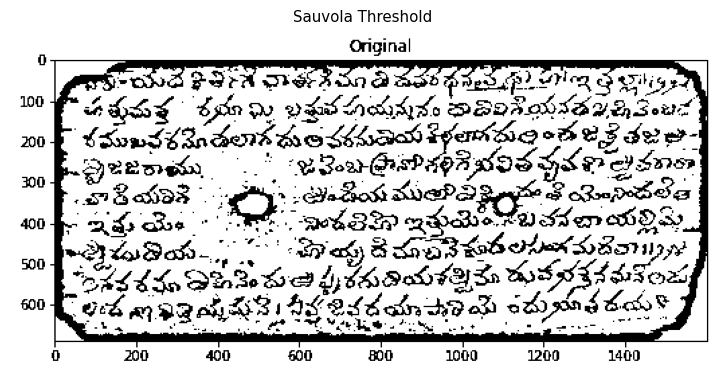

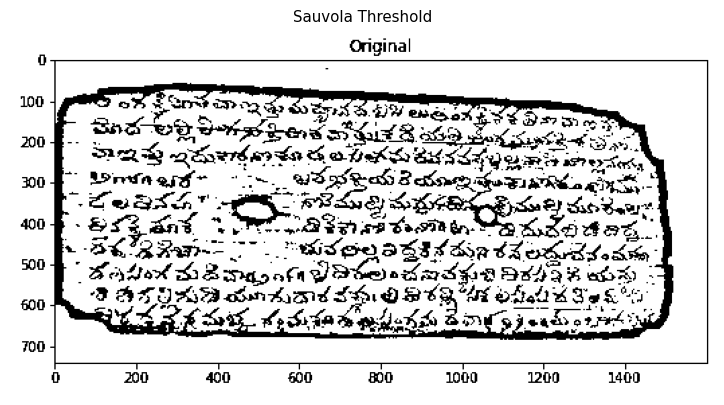

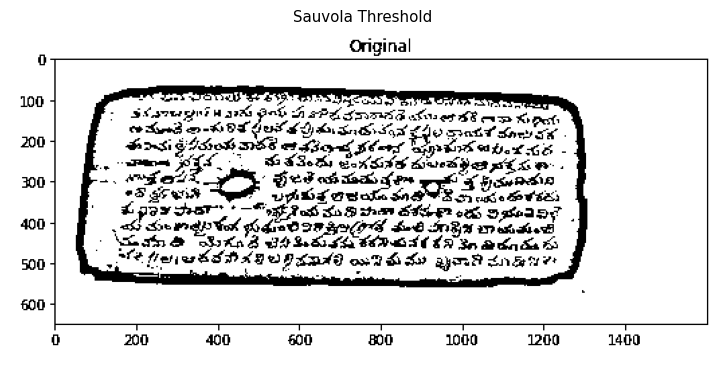

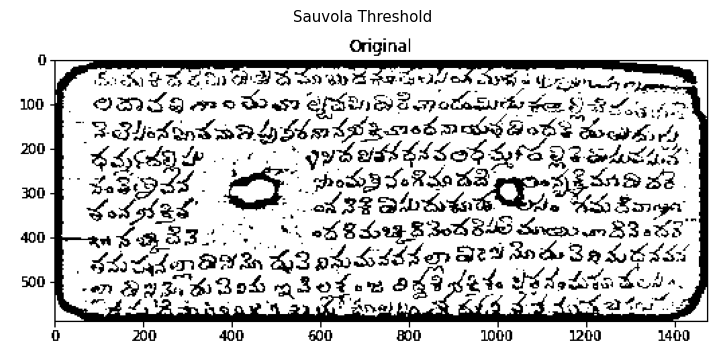

In [4]:
import matplotlib
import matplotlib.pyplot as plt

from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)

def sauvola_threshold(img_path):

    matplotlib.rcParams['font.size'] = 9

    img = Image.open(img_path).convert('L')
    npimage = np.asarray(img)
    image = npimage

    window_size = 15
    thresh_sauvola = threshold_sauvola(image, window_size=window_size)

    binary_sauvola = image > thresh_sauvola

    plt.figure(figsize=(20, 20))

    plt.subplot(2, 2, 4)
    plt.imshow(binary_sauvola, cmap=plt.cm.gray)
    plt.title('Sauvola Threshold')
    plt.axis('off')

    plt.show()
    
    final_sauvola = Image.fromarray(binary_sauvola)
    final_sauvola = final_sauvola.convert("L")
    img_name = img_path.split('/')[-1]
    output_path = '../quantitative_analysis/sauvola_results/' + img_name
    final_sauvola.save(output_path)
    
# Iterate through all images in the dataset and apply binarization
for i in range(1, 6):
    img_path = "../quantitative_analysis/dataset/" + str(i) + ".bmp"
    sauvola_threshold(img_path)

In [5]:
# Find Mean Squared Error for every pair of images

# Arrays to hold all the MSE values for both algorithms
mse_igt_arr = []
mse_sauvola_arr = []

for it in range(1, 6):
    img_path_gt = "../quantitative_analysis/ground_truths/" + str(it) + "_gt.bmp"
    img_path_igt = "../quantitative_analysis/igt_results/" + str(it) + ".bmp"
    img_path_sauvola = "../quantitative_analysis/sauvola_results/" + str(it) + ".bmp"
    
    # Open images
    img_gt = Image.open(img_path_gt).convert('L')
    img_igt = Image.open(img_path_igt).convert('L')
    img_sauvola = Image.open(img_path_sauvola).convert('L')
    
    # Convert to numpy array
    npimage_gt = np.asarray(img_gt)
    npimage_igt = np.asarray(img_igt)
    npimage_sauvola = np.asarray(img_sauvola)
    
    # Check if dimensions match
    assert npimage_gt.shape == npimage_igt.shape
    assert npimage_gt.shape == npimage_sauvola.shape

    m, n = npimage_gt.shape
    print(m, n)
    
    # Image is in grayscale (0 - 255), first convert to binary (0 or 1)
    binimage_gt = np.zeros((m, n))
    binimage_igt = np.zeros((m, n))
    binimage_sauvola = np.zeros((m, n))
    
    # MSE can be found in this loop itself but another loop is added to show clarity to the calculation
    for i in range(0, m):
        for j in range(0, n):
            if npimage_gt[i][j] == 255:
                binimage_gt[i][j] = 1
            if npimage_igt[i][j] == 255:
                binimage_igt[i][j] = 1
            if npimage_sauvola[i][j] == 255:
                binimage_sauvola[i][j] = 1
    
#     print(binimage_gt)
#     print(binimage_igt)
#     print(binimage_sauvola)

    mse_igt = 0
    mse_sauvola = 0
    for i in range(0, m):
        for j in range(0, n):
            mse_igt += (binimage_igt[i][j] - binimage_gt[i][j])**2
            mse_sauvola += (binimage_sauvola[i][j] - binimage_gt[i][j])**2
    # Divide total by number of pixels
    mse_igt /= (m * n)
    mse_sauvola /= (m * n)
    
    # Add values to array
    mse_igt_arr.append(mse_igt)
    mse_sauvola_arr.append(mse_sauvola)

230 525
256 525
272 525
243 525
241 525


In [6]:
print(mse_igt_arr)
print(mse_sauvola_arr)

[0.2719089026915114, 0.27360119047619047, 0.2178501400560224, 0.17789535567313344, 0.2741355463347165]
[0.33744927536231883, 0.3491294642857143, 0.27619747899159663, 0.22259847148736037, 0.34997826516498715]


In [7]:
def PSNR(ground_truth, binarized):
    mse = np.mean((ground_truth - binarized) ** 2)
    print(mse)
    
    # MSE is zero means no noise is present in the signal.
    # Therefore PSNR have no importance.
    if(mse == 0):
        return 100
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

psnr_igt_arr = []
psnr_sauvola_arr = []

for img in range(1, 6):
    img_path_gt = "../quantitative_analysis/ground_truths/" + str(img) + "_gt.bmp"
    img_path_igt = "../quantitative_analysis/igt_results/" + str(img) + ".bmp"
    img_path_sauvola = "../quantitative_analysis/sauvola_results/" + str(img) + ".bmp"
    
    ground_truth = cv2.imread(img_path_gt)
    ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)
    
    igt = cv2.imread(img_path_igt)
    igt = cv2.cvtColor(igt, cv2.COLOR_BGR2GRAY)
    
    sauvola = cv2.imread(img_path_sauvola)
    sauvola = cv2.cvtColor(sauvola, cv2.COLOR_BGR2GRAY)
    
    m, n = ground_truth.shape
    
    # Image is in grayscale (0 - 255), first convert to binary (0 or 1)
    binimage_gt = np.zeros((m, n))
    binimage_igt = np.zeros((m, n))
    binimage_sauvola = np.zeros((m, n))

    for i in range(0, m):
        for j in range(0, n):
            if ground_truth[i][j] == 255:
                binimage_gt[i][j] = 1
            if igt[i][j] == 255:
                binimage_igt[i][j] = 1
            if sauvola[i][j] == 255:
                binimage_sauvola[i][j] = 1
    
    # Get PSNR
    psnr_igt = PSNR(binimage_gt, binimage_igt)
    psnr_sauvola = PSNR(binimage_gt, binimage_sauvola)
    
    # Add values to array
    psnr_igt_arr.append(psnr_igt)
    psnr_sauvola_arr.append(psnr_sauvola)

0.2719089026915114
0.33744927536231883
0.27360119047619047
0.3491294642857143
0.2178501400560224
0.27619747899159663
0.17789535567313344
0.22259847148736037
0.2741355463347165
0.34997826516498715


In [8]:
print(psnr_igt_arr)
print(psnr_sauvola_arr)

[5.655765727490163, 5.6288201727313645, 6.618421565198815, 7.498353899254012, 5.620346471452741]
[4.717915001244123, 4.570134979726268, 5.587802897872033, 6.524778221526315, 4.559589259697583]
